In [1]:
############# AT THE START, WE INSTALL PACKAGES WE NEED ###################################

# We use a package that might be new to some of you, called "INLA" 
# This package helps implement Bayesian methods and helps make some of our steps fast/easy to implement
# We will explain it as we go through this code 

############# OPEN R, THEN RUN THE FOLLOWING COMMAND ###################

install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
install.packages("fmesher", dependencies = TRUE)
install.packages("MatrixModels", type = "source")
install.packages("exactextractr")
install.packages("sn" ,dependencies = TRUE)
packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis","sn","fmesher","exactextractr","fields")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE, quietly=TRUE)
    }
})
Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

##### THE FOLLOWING COMMANDS ARE FOR THE INSTALLATION OF PACKAGES ON NASA MAAP #####
##### CONDA-FORGE YOUR WAY THROUGH PACKAGES THAT DID NOT INSTALL ##########

# conda install conda-forge::r-fmesher
# conda install conda-forge::r-exactextractr
# conda install conda-forge::r-sn
# conda install conda-forge::r-inlabru
# conda install conda-forge::r-fields

In [1]:
############## LOAD PACKAGES ###########

library("fmesher")
library(MatrixModels)
library(Matrix)
library(INLA)
library(inlabru)
library("jpeg")

library(sf)
library(terra)
library(dplyr)
library(spdep)
library(raster)
library(exactextractr)

library(ggplot2)
library(viridis)
library(sn)

Warning message:
“package ‘INLA’ was built under R version 4.4.2”
This is INLA_24.12.11 built 2024-12-11 19:58:26 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation

Linking to GEOS 3.12.1, GDAL 3.8.5, PROJ 9.4.0; sf_use_s2() is TRUE

terra 1.7.78


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sp


Attaching package: ‘raster’


The following object is masked from ‘package:dplyr’:

    select


Loading required

In [10]:
###############################################
###### READ CCI TILES AND MOSAIC TILES ########
###############################################

# gpkg_file <- "/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/PSU_values_Peru.gpkg"  
# gpkg <- st_read(gpkg_file) %>% st_transform(crs=4326)
# gpkg_bbox <- st_bbox(gpkg)
# crs_gpkg <- st_crs(gpkg)

# folder_path <- "/projects/my-public-bucket/Data/Biomass_maps/CCI_2021_v5/dap.ceda.ac.uk/neodc/esacci/biomass/data/agb/maps/v5.01/geotiff/2021"
# tiff_files <- list.files(folder_path, pattern = "*_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2021-fv5.0.tif", full.names = TRUE)
# overlapping_tiffs <- list()

# for (tiff_file in tiff_files) {
#   raster <- rast(tiff_file)
#   raster_bbox <- ext(raster)
#   raster_bbox_sf <- st_sfc(st_polygon(list(matrix(c(raster_bbox[1], raster_bbox[3],  # xmin, ymin
#                                                    raster_bbox[2], raster_bbox[3],  # xmax, ymin
#                                                    raster_bbox[2], raster_bbox[4],  # xmax, ymax
#                                                    raster_bbox[1], raster_bbox[4],  # xmin, ymax
#                                                    raster_bbox[1], raster_bbox[3]),  # Repeating first point to close polygon
#                                                  ncol = 2, byrow = TRUE))))
#   gpkg_bbox_sf <- st_sfc(st_polygon(list(matrix(c(gpkg_bbox["xmin"], gpkg_bbox["ymin"],  # xmin, ymin
#                                                    gpkg_bbox["xmax"], gpkg_bbox["ymin"],  # xmax, ymin
#                                                    gpkg_bbox["xmax"], gpkg_bbox["ymax"],  # xmax, ymax
#                                                    gpkg_bbox["xmin"], gpkg_bbox["ymax"],  # xmin, ymax
#                                                    gpkg_bbox["xmin"], gpkg_bbox["ymin"]),  # Repeating first point to close polygon
#                                                  ncol = 2, byrow = TRUE))))
#   overlap <- st_intersects(gpkg_bbox_sf, raster_bbox_sf, sparse = FALSE)
#   if (any(overlap)) {
#     overlapping_tiffs <- append(overlapping_tiffs, tiff_file)
#   }
# }

# print(overlapping_tiffs)

# rasters <- lapply(overlapping_tiffs, rast)
# merged_raster <- do.call(merge, rasters)
# output_file <- "/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/CCI_Peru.tif"
# writeRaster(merged_raster, output_file, gdal = c("COMPRESS=LZW", "TILED=YES", "BIGTIFF=YES"),overwrite = TRUE)

# output_file <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/CCI_Peru.tif")%>% project("epsg:6933")
# output_file <- ("/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/CCI_Peru_6933.tif")
# writeRaster(merged_raster, output_file, gdal = c("COMPRESS=LZW", "TILED=YES", "BIGTIFF=YES"),overwrite = TRUE)

In [13]:
GEDI <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/Peru_country_MON_L4A.tif") %>% project("epsg:6933")
writeRaster(GEDI, "/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/GEDI_Peru_500m.tif", gdal = c("COMPRESS=LZW", "TILED=YES", "BIGTIFF=YES"),overwrite = TRUE)

In [35]:
Peru <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Peru_country.gpkg") %>% st_transform(crs=6933)
nfi_and_covs <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/PSU_values_Peru.gpkg") %>% st_transform(crs=6933)
nfi_and_covs <- st_intersection(nfi_and_covs, Peru)
nfi_and_covs$X <- (as.data.frame(st_coordinates(nfi_and_covs)))$X
nfi_and_covs$Y <- (as.data.frame(st_coordinates(nfi_and_covs)))$Y

CCI <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/CCI_Peru_6933.tif")
CCI_AGB <- exactextractr::exact_extract(CCI,st_buffer(nfi_and_covs,400), 'mean')
nfi_and_covs$CCI_AGB <- CCI_AGB

GEDI <- rast("/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/GEDI_Peru_500m.tif")
GEDI_AGB <- exactextractr::exact_extract(GEDI,st_buffer(nfi_and_covs,400), 'mean')
nfi_and_covs$GEDI_AGB <- GEDI_AGB

write.csv(nfi_and_covs %>% st_drop_geometry(), "/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/DATA.csv")
file.remove("/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/NFI_and_COVS.gpkg")
st_write(nfi_and_covs,"/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/NFI_and_COVS.gpkg")

Reading layer `ne_10m_admin_0_countries' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Peru_country.gpkg' 
  using driver `GPKG'
Simple feature collection with 1 feature and 168 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -81.33756 ymin: -18.33775 xmax: -68.68425 ymax: -0.02909271
Geodetic CRS:  WGS 84
Reading layer `psu_values_peru' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/PSU_values_Peru.gpkg' 
  using driver `GPKG'
Simple feature collection with 322 features and 9 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 111366.6 ymin: 8543878 xmax: 1189990 ymax: 9984330
Projected CRS: WGS 84 / UTM zone 18S


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message in .local(x, y, ...):
“Polygons transformed to raster CRS (EPSG:4326)”
Cannot preload entire working area of 159154600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |======================================================================| 100%


[1] TRUE

Writing layer `NFI_and_COVS' to data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/NFI_and_COVS.gpkg' using driver `GPKG'
Writing 319 features with 181 fields and geometry type Point.


Reading layer `NFI_and_COVS' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/NFI_and_COVS.gpkg' 
  using driver `GPKG'
Simple feature collection with 319 features and 181 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -7575025 ymin: -1658569 xmax: -6640991 ymax: -18086.63
Projected CRS: WGS 84 / NSIDC EASE-Grid 2.0 Global


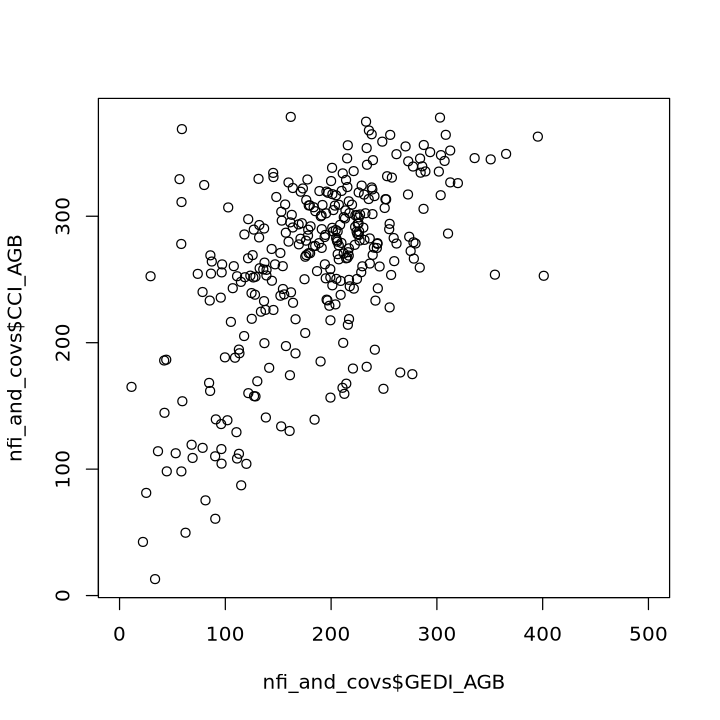

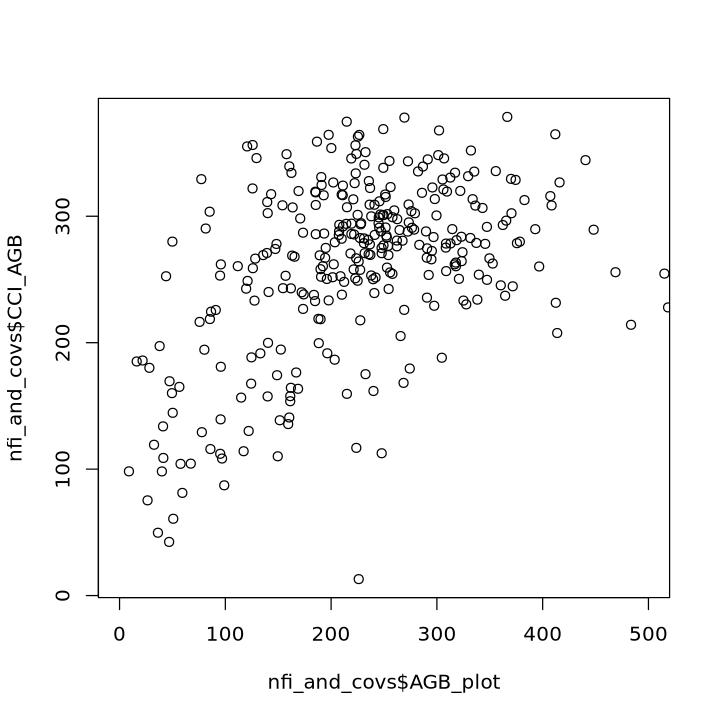

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'summary': invalid power in formula


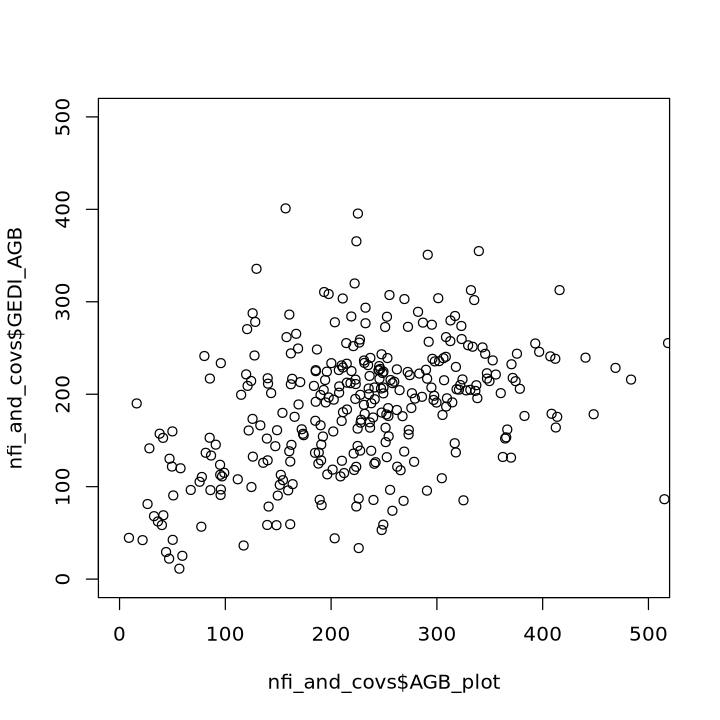

In [51]:
nfi_and_covs <- st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/NFI_and_COVS.gpkg")  %>% st_transform("epsg:6933")
nfi_and_covs$AGB_plot <- nfi_and_covs$AGB_cluster..Mg.ha.

plot(nfi_and_covs$GEDI_AGB,nfi_and_covs$CCI_AGB,xlim=c(0,500))
plot(nfi_and_covs$AGB_plot,nfi_and_covs$CCI_AGB,xlim=c(0,500))
plot(nfi_and_covs$AGB_plot,nfi_and_covs$GEDI_AGB,xlim=c(0,500),ylim=c(0,500))

summary(lm(nfi_and_covs$AGB_plot ~ nfi_and_covs$GEDI_AGB * nfi_and_covs$CCI_AGB))
plot(nfi_and_covs)

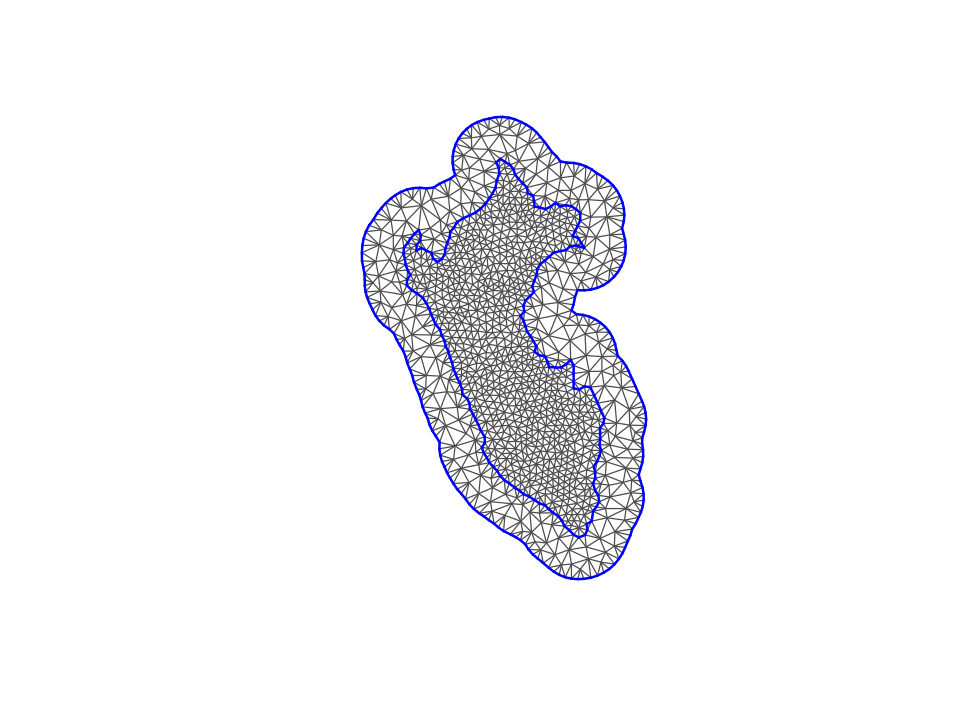

In [48]:
###################################################################
################ BEGIN MODELING - CREATE INLA MESH ################
###################################################################

options(repr.plot.width=8, repr.plot.height=6)

DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/DATA.csv")
DATA$AGB_plot <- DATA$AGB_cluster..Mg.ha.

# DATA <- DATA[DATA$GEDI_AGB > 0,]
# DATA <- DATA[DATA$AGB_plot > 0,]
# DATA <- DATA[DATA$CCI_AGB > 0,]
factor <- (1/4)
DATA$AGB_plot <- (DATA$AGB_plot)^factor

loc.plot <- data.matrix(as.data.frame(cbind(DATA$X,DATA$Y)))
nfi.agbd <- DATA$AGB_plot
gedi.agbd <- DATA$GEDI_AGB
cci.agbd <- DATA$CCI_AGB

max.edge = 50*10^3
Peru.buffer = st_buffer(Peru, dist = max.edge*5) # We also make a 5 km buffer around Peru to prevent boundary effects.
mesh = inla.mesh.2d(boundary = list(as(Peru, "Spatial"), as(Peru.buffer, "Spatial")), max.edge = c(max.edge, 3*max.edge), cutoff = 2*max.edge/3, offset = c(max.edge, 5*max.edge)) 
k = mesh$n ### This is the resulting number of vertices
loc.plot <- data.matrix(loc.plot) #In case loc.plot is a df rather than matrix, use "loc.plot <- data.matrix(loc.plot)"
plot(mesh)

n.plot = nrow(loc.plot)
A.plot = inla.spde.make.A(mesh = mesh, loc = loc.plot) # make a new projector matrix with the new mesh and the same plot locations. 

Time used:
    Pre = 0.791, Running = 65.4, Post = 0.226, Total = 66.4 
Fixed effects:
           mean    sd 0.025quant 0.5quant 0.975quant  mode kld
intercept 2.693 0.117      2.464    2.693      2.922 2.693   0
L4A       0.002 0.001      0.001    0.002      0.003 0.002   0
CCI       0.003 0.001      0.002    0.003      0.004 0.003   0

Random effects:
  Name	  Model
    alpha.spat SPDE2 model
   beta.spat SPDE2 model
   eta.spat SPDE2 model

Model hyperparameters:
                                            mean       sd 0.025quant 0.5quant
Precision for the Gaussian observations 7.50e+00 7.95e-01   6.03e+00 7.47e+00
Range for alpha.spat                    1.05e+05 4.92e+04   3.91e+04 9.48e+04
Stdev for alpha.spat                    2.39e-01 4.90e-02   1.53e-01 2.35e-01
Range for beta.spat                     9.32e+05 1.19e+06   9.82e+04 5.79e+05
Stdev for beta.spat                     1.00e-03 0.00e+00   0.00e+00 1.00e-03
Range for eta.spat                      3.73e+05 3.55e+05   1

[1] 0.9278997

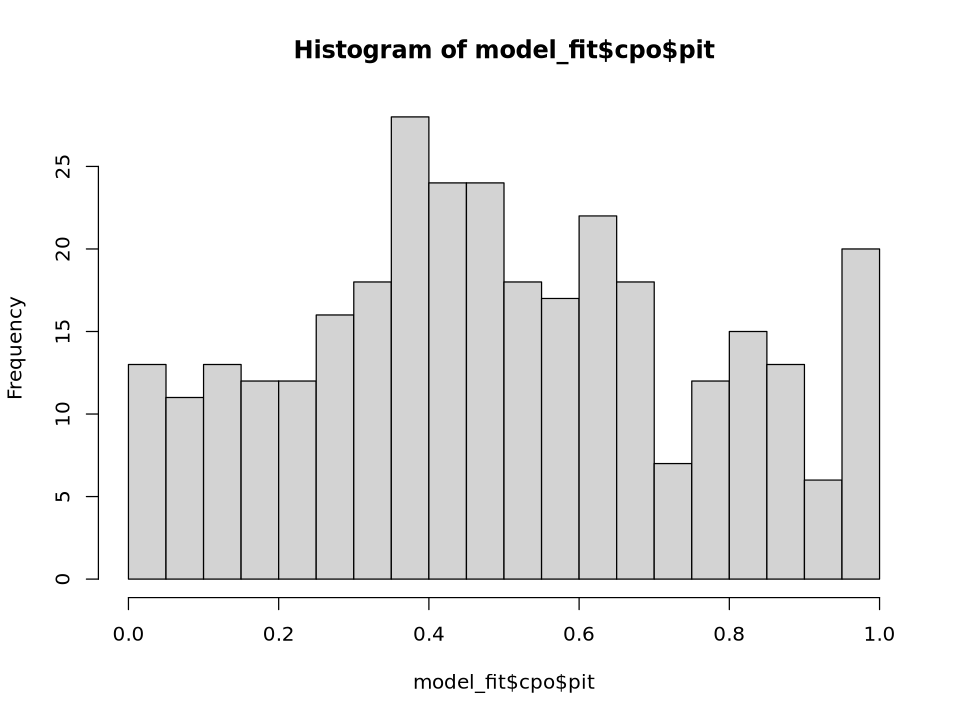

In [49]:
###############################################################
################ SET PRIORS AND RUN MODEL #####################
###############################################################

# Priors for the varying intercept alpha_tilde
spde.alpha = inla.spde2.pcmatern(mesh, 
                                 prior.range = c(30*10^3, 0.01), # This says the probability that the range is LESS than 30 km is 0.01
                                 prior.sigma = c(60, 0.01)) # This says the probability that the SD is GREATER than 60 Mg/ha is 0.01

# Priors for the varying coefficient beta_tilde
spde.beta = inla.spde2.pcmatern(mesh, 
                                prior.range = c(30*10^3, 0.01), # Same interpretations as above here
                                prior.sigma = c(1, 0.5)) # This says the probability that the SD is GREATER than 1 is 0.5


# Priors for the varying coefficient eta_tilde
spde.eta = inla.spde2.pcmatern(mesh, 
                               prior.range = c(30*10^3, 0.01), # Same interpretations as above here
                               prior.sigma = c(1, 0.5)) # This says the probability that the SD is GREATER than 1 is 0.5


### Construct our formula #####
formula = agbd ~
  -1 + # removes the automatic intercept so you can include your named intercept
  intercept + 
  L4A + 
  CCI + 
  f(alpha.spat, model = spde.alpha) + 
  f(beta.spat, model = spde.beta) + 
  f(eta.spat, model = spde.eta)

## Arrange our data so we can supply it to INLA to input in the formula above #####
stack = inla.stack(data = list(agbd = nfi.agbd),
                   A = list(1, # tell INLA we expect an intercept, and the projection matrix is just "1"
                            1, # tell INLA we expect a GEDI value, and the projection matrix for its parameter is just "1"
                            1, # tell INLA we expect a CCI value, and the projection matrix for its parameter is just "1"
                            A.plot, # tell INLA we have a mesh projected onto the plot locations for alpha-tilde 
                            Diagonal(x = gedi.agbd)%*%A.plot, # tell INLA to multiply our mesh with GEDI values for Beta-tilde
                            Diagonal(x = cci.agbd)%*%A.plot), # tell INLA to multiply our mesh with CCI values for eta-tilde
                   effects = list(
                     intercept = rep(1, n.plot), # The intercept just given an index equal to 1
                     L4A = gedi.agbd, # Supply INLA with the GEDI values
                     CCI = cci.agbd, # Supply INLA with the CCI values
                     alpha.spat = 1:k, # The random effects just need to given unique indices at each mesh node.
                     beta.spat = 1:k, #, # The random effects just need to given unique indices at each mesh node.
                     eta.spat = 1:k # The random effects just need to given unique indices at each mesh node.
                   ))

model_fit = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T, cpo = T),
                 control.inla = list(int.strategy = "eb"), # EB just fixes the hyperparameters at their maximum posterior (like maximum likelihood, but accounting for priors) values. The other methods manually integrate across the range of possible values.
                 verbose = TRUE)

summary(model_fit)
save(model_fit, file = "/projects/my-public-bucket/Data/NASA_CMS_2023/PERU/Data/INLA_model_fit.RData")
hist(model_fit$cpo$pit, breaks = 20) 

PITs <- model_fit$cpo$pit
length(PITs[PITs >= 0.025 & PITs <= 0.975])/length(PITs)

Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_point()`).”


[1] 0.5018127

[1] 78.54801

[1] 1.478489

[1] 0.9435737

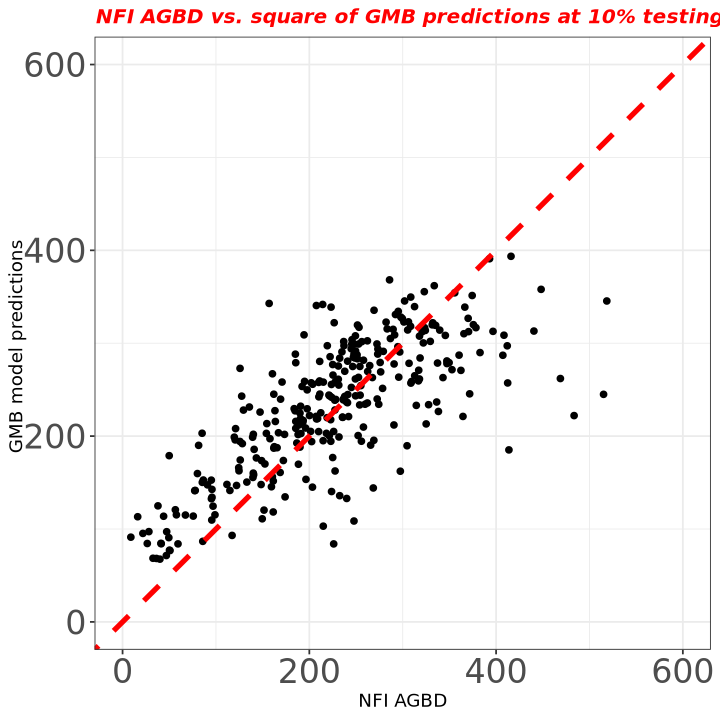

In [50]:
###############################################################
######## SCATTER PLOT OF PREDICTIONS VS. NFI-ESTIMATES ########
###############################################################

samples = inla.posterior.sample(n = 250, result = model_fit) # Draw posterior samples from our model fit 

# Our model function
pred_fun = function(...){
  drop(intercept + 
         gedi.agbd*L4A +
         cci.agbd*CCI +
         A.plot%*%alpha.spat[1:k] +   
         Diagonal(x = gedi.agbd)%*%A.plot%*%beta.spat[1:k] + 
         Diagonal(x = cci.agbd)%*%A.plot%*%eta.spat[1:k]) +
    rnorm(nrow(A.plot), sd = sqrt(1/theta[1])) 
}

# Generate prediction samples, i.e. ask INLA to use the prediction function and samples to make predictions. 
pred.samples = (inla.posterior.sample.eval(fun = pred_fun,samples = samples)) #

# Model mean AGBD expectations and SD's at the grid locations
pred.mu = Matrix::rowMeans(pred.samples^(1/factor),na.rm=TRUE)
pred.sd = apply(pred.samples^(1/factor), 1, sd)
options(repr.plot.width=5, repr.plot.height=5)

OUTPUT <- do.call(rbind, Map(data.frame, PRED=pred.mu, NFI=nfi.agbd^(1/factor), PRED.SD=pred.sd, RES=nfi.agbd^(1/factor)-pred.mu))
options(repr.plot.width=6, repr.plot.height=6)
ggplot(data = OUTPUT, aes(x = NFI,y = PRED))+ geom_point()  + geom_abline(size=0.5,linetype=2,col="red",lwd=1.5) + theme_bw() + xlim(0,600) + ylim(0,600) + xlab("NFI AGBD") + ylab("GMB model predictions ") + ggtitle("NFI AGBD vs. square of GMB predictions at 10% testing locations") + theme(plot.title = element_text(color="red", size=12, face="bold.italic"),axis.text=element_text(size=20))

####################################################################
######################## HEURISTICS: R2 AND RMSE ###################
####################################################################

R2_backtrans = 1 - (sum((pred.mu - nfi.agbd^(1/factor))^2,na.rm=TRUE)/sum((nfi.agbd^(1/factor) - mean(nfi.agbd^(1/factor),na.rm=TRUE))^2,na.rm=TRUE))
R2_backtrans
RMSE = sqrt(mean((pred.mu - nfi.agbd^(1/factor))^2,na.rm=TRUE))
RMSE
BIAS = mean(pred.mu,na.rm=TRUE) - mean(nfi.agbd^(1/factor),na.rm=TRUE)
BIAS # Mg/ha

###########################################################################
############## RATE OF OVERLAP OF CREDIBILITY INTERVALS ###################
###########################################################################

Q25 <- apply(pred.samples^(1/factor), 1, quantile, probs = c(0.025), na.rm=TRUE)
Q975 <- apply(pred.samples^(1/factor), 1, quantile, probs = c(0.975), na.rm=TRUE)
sum((nfi.agbd^(1/factor) >= Q25) & (nfi.agbd^(1/factor) <= Q975), na.rm=TRUE)/length(nfi.agbd^(1/factor))